**Movie ratings over time**

Has perception of specific movie genres changed over time? 
Is there a relation between when a comedy film was released and its rating? 
Do directors or actor cast influence a comedy's rating more?

Let's find out by going through the IMDb catalogue of all movie data. 

In [3]:
### Run this cell to import requests module to fetch data from IMDB.
### The files are in GZ format, so need GZIP to work with those.
import requests
import gzip
import shutil
import os

In [6]:
urls = {
    'name.basics': 'https://datasets.imdbws.com/name.basics.tsv.gz',
    'title.basics': 'https://datasets.imdbws.com/title.basics.tsv.gz',
    'title.ratings': 'https://datasets.imdbws.com/title.ratings.tsv.gz'
}

In [7]:
### This cell will fethc files from IMDB data, and overwrite existing files.
### The data is refreshed daily, so there's not much benefit of running this cell more than once a day.
### Those files can be quite large (800, 900, 200MB). 

def download_and_unarchive_tsv_files(urls):
    for name, url in urls.items():
        file_name = f"{name}.tsv.gz"
        tsv_file_name = f"{name}.tsv"

        # Download the file
        with requests.get(url, stream=True) as response:
            with open(file_name, 'wb') as f:
                shutil.copyfileobj(response.raw, f)

        # Unarchive the file
        with gzip.open(file_name, 'rb') as f_in:
            with open(tsv_file_name, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        # Remove the archived file
        os.remove(file_name)

# Call the function
download_and_unarchive_tsv_files(urls)

In [8]:
### Run this cell to import modules used to analyze data.

import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns

## Realistically, this project could have been done through pyplot without using Seaborn. I just wanted to try it out. 

In [72]:
## Set seaborn style
sns.set_theme(style="dark")

## Set pandas display options to see more rows:

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


The data comes from IMDb's datasets. Run the first 3 cells to download the files again.

Note: if you already have files with those names, the functino will replace the existing files. If you want to keep a snapshot of the data, change the naming convention.

In [9]:
##Importing the movie names and basic stats as a DataFrame from a TSV, using a tab as a delimiter.
name_df = pd.read_csv('title.basics.tsv', delimiter = '\t')

##Showing the first 10 rows of data to see columns and data format.
##Pandas didn't display the DataFrame very nicely by default, so I tried out IPython's display.
display(name_df.head())


/var/folders/ms/k8b53l1s5t1620nq2r0qr7y00000gn/T/ipykernel_13309/1412913756.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  name_df = pd.read_csv('title.basics.tsv', delimiter = '\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


Data looks great. Potential challenges include:

- All columns could have empty values, specified as \N
- The Genres column has multiple genres in the same column, separated by comma. This makes analyzing a single genre slightly more difficult.
- Data doesn't have ratings, or the number of votes.
- There are ~10M rows of data for different media types (TV, Talkshow, Shorts, etc.). I am only really interested in everything produced for release in Cinemas (titleType == movie)

Ratings and number of votes are in a separate file, with tconst as the unique ID. This means the data can be joined to the dataframe, based on tconst being the same across 2 DataFrames.

Creating a new DataFrame with Ratings to join to the movie titles. 

In [4]:
ratings_df = pd.read_csv('title.ratings.tsv', delimiter = '\t')

display(ratings_df.head())

,tconst,averageRating,numVotes
0,tt0000001,5.7,2008
1,tt0000002,5.8,270
2,tt0000003,6.5,1923
3,tt0000004,5.5,178
4,tt0000005,6.2,2698


In [5]:
## Filter out only relevant data, items meant for cinema release.
name_filtered_df = name_df[name_df['titleType'] == 'movie']

## Join the Movie Titles with Movie Ratings, based on 'tconst' - this is the movie ID provided by IMDB.
names_and_ratings_df = name_filtered_df.set_index('tconst').join(ratings_df.set_index('tconst'))

display(names_and_ratings_df.head())
print(names_and_ratings_df.size)

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207.0
tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484.0
tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15.0
tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,857.0
tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21.0


6653260


In [6]:
names_and_ratings_df = names_and_ratings_df[names_and_ratings_df['genres'] != '\\N']

# Display the modified DataFrame

display(names_and_ratings_df.head())

<class 'pandas.core.frame.DataFrame'>


,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207.0
tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484.0
tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,857.0
tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21.0
tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.3,25.0


In [7]:
## Each movie could have up to 3 genres, separated by comma. 

# # Flatten the list of lists into a single list, ignoring empty strings
flat_genres = [genre for genres in names_and_ratings_df['genres'].str.split(',') for genre in genres if genre]

# Create a new list with unique values
unique_genres = list(set(flat_genres))

# Display the unique genres
print("Unique Genres:", unique_genres)

genre_counts = pd.Series(flat_genres).value_counts()

print(genre_counts)

Unique Genres: ['Western', 'Sci-Fi', 'Reality-TV', 'Drama', 'Adult', 'Biography', 'Fantasy', 'History', 'Mystery', 'Adventure', 'Comedy', 'Film-Noir', 'Sport', 'Music', 'Short', 'Horror', 'Musical', 'Romance', 'Game-Show', 'Action', 'Family', 'Animation', 'Talk-Show', 'Thriller', 'War', 'News', 'Crime', 'Documentary']
Drama          240158
Documentary    127119
Comedy         111729
Action          55307
Romance         48549
Thriller        46041
Horror          39025
Crime           38293
Adventure       28840
Family          18163
Mystery         17852
Biography       17686
Fantasy         15782
History         14695
Sci-Fi          14348
Music           13103
Musical         10449
War              9434
Animation        9356
Adult            9228
Western          8256
Sport            7603
News             1455
Film-Noir         883
Reality-TV        531
Talk-Show         181
Game-Show          28
Short               1
Name: count, dtype: int64


What can ew conclude from the number of movies released in cinema for each genre?

Drama is the most prevalent genre, with a significantly higher count than any other genre. This suggests that drama films are widely produced and/or popular among audiences.
Documentary and comedy are the next most common genres after drama. This indicates a significant interest in real-life storytelling (documentary) and comedic content.

There is a significant imbalance in the representation of different genres, with drama, documentary, and comedy dominating the dataset, while certain genres like Game-Show and Short have very limited representation.

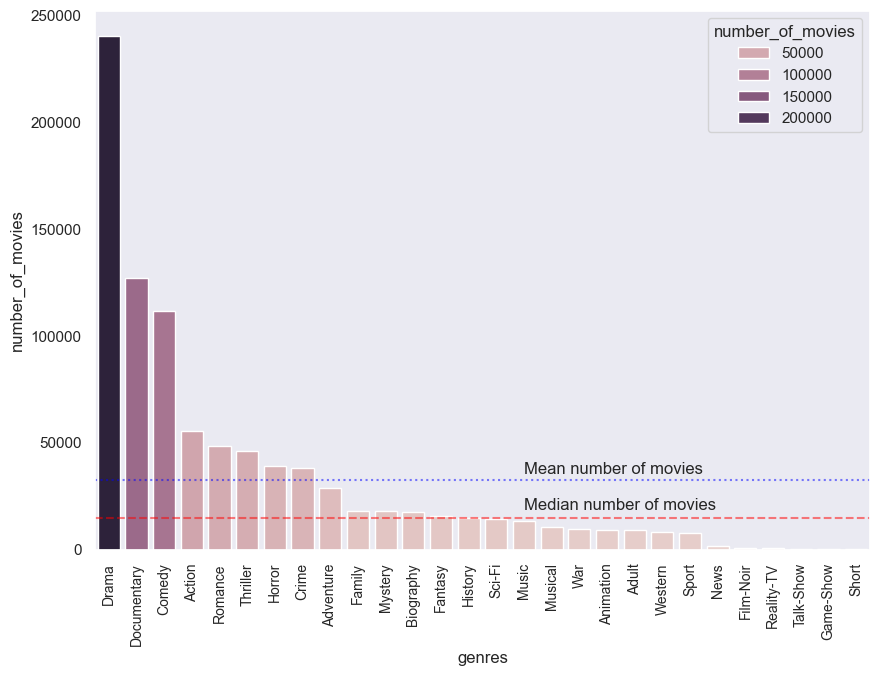

In [8]:
genre_counts_df = genre_counts.to_frame().reset_index()

genre_counts_df.rename(columns = {'index': 'genres', 'count': 'number_of_movies'}, inplace = True)
x = genre_counts_df.genres
y = genre_counts_df.number_of_movies

plt.figure(figsize = (10,7))
movie_counts = sns.barplot(x = genre_counts_df.genres, y = genre_counts_df.number_of_movies, hue = genre_counts_df.number_of_movies)
plt.xticks(rotation=90, size = 10)
movie_counts.text(15, genre_counts_df.number_of_movies.median()*1.3, "Median number of movies")
movie_counts.text(15, genre_counts_df.number_of_movies.mean()*1.1, "Mean number of movies")
movie_counts.axhline(y = genre_counts_df.number_of_movies.median(), color = 'red', linestyle = '--', label = 'Median', alpha = 0.5)
movie_counts.axhline(y = genre_counts_df.number_of_movies.mean(), color = 'blue', linestyle = ':', label = 'Mean', alpha = 0.5)

In [9]:
names_and_ratings_df_copy2 = names_and_ratings_df.copy()

names_and_ratings_df_copy2.reset_index(inplace = True)

# Split the 'genres' column into multiple columns
genres_split = names_and_ratings_df_copy2['genres'].str.split(',', expand=True)

# Concatenate the new genre columns with the original DataFrame
names_and_ratings_df_copy2 = pd.concat([names_and_ratings_df_copy2, genres_split], axis=1)

names_and_ratings_df_copy2 = names_and_ratings_df_copy2.rename(columns = {0 : 'genre_1', 1: 'genre_2', 2: 'genre_3'})

id_vars = names_and_ratings_df_copy2.columns.difference(['genres', 'genre_1', 'genre_2', 'genre_3'])
names_and_ratings_df_melted = pd.melt(names_and_ratings_df_copy2, id_vars=id_vars, value_vars=['genre_1', 'genre_2', 'genre_3'])

# Display the melted DataFrame
display(names_and_ratings_df_melted.head(100))

,averageRating,endYear,isAdult,numVotes,originalTitle,primaryTitle,runtimeMinutes,startYear,tconst,titleType,variable,value
0,5.3,\N,0,207.0,Miss Jerry,Miss Jerry,45,1894,tt0000009,movie,genre_1,Romance
1,5.3,\N,0,484.0,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,100,1897,tt0000147,movie,genre_1,Documentary
2,6.0,\N,0,857.0,The Story of the Kelly Gang,The Story of the Kelly Gang,70,1906,tt0000574,movie,genre_1,Action
3,5.0,\N,0,21.0,L'enfant prodigue,The Prodigal Son,90,1907,tt0000591,movie,genre_1,Drama
4,4.3,\N,0,25.0,Robbery Under Arms,Robbery Under Arms,\N,1907,tt0000615,movie,genre_1,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,\N,0,NaN,The Criminal Path,The Criminal Path,\N,1914,tt0002772,movie,genre_1,Crime
96,NaN,\N,0,NaN,Le dernier pardon,Le dernier pardon,\N,1913,tt0002798,movie,genre_1,Comedy
97,NaN,\N,0,NaN,Desastre do Monoplano Gnome na Amadora,Desastre do Monoplano Gnome na Amadora,\N,1913,tt0002799,movie,genre_1,Documentary
98,NaN,\N,0,NaN,East Lynne,East Lynne,69,1913,tt0002820,movie,genre_1,Drama


In [10]:
# #What are some general statistics about our data?
# #How is the data distributed?
# #What is the variation like?
# #What is the genre with highest average ratings?
# #Which genre has the highest median?

#Had errors due to \N or missing values in runtimeMinutes column.
names_and_ratings_df_melted.dropna()
names_and_ratings_df_melted = names_and_ratings_df_melted.loc[names_and_ratings_df_melted['runtimeMinutes'] != '\\N']
names_and_ratings_df_melted['runtimeMinutes'] = pd.to_numeric(names_and_ratings_df_melted['runtimeMinutes'])

for genre in names_and_ratings_df_melted.value.unique():
    print ("{genre} statistics: \n".format(genre = genre))
    print ("Rating mean: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].averageRating.mean()))
    print ("Rating median: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].averageRating.median()))
    print ("Rating standard deviation: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].averageRating.std()))
    print ("Number of votes mean: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].numVotes.mean()))
    print ("Number of votes median: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].numVotes.median()))
    print ("Number of votes standard deviation: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].numVotes.std()))
    print ("Runtime in minutes mean: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].runtimeMinutes.mean()))
    print ("Runtime in minutes median: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].runtimeMinutes.median()))
    print ("Runtime in minutes standard deviation: {value}".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].runtimeMinutes.std()))
    print ("Total number of movies: {value} \n".format(value = names_and_ratings_df_melted[names_and_ratings_df_melted['value'] == genre].size))

Romance statistics: 

Rating mean: 6.102433349491033
Rating median: 6.2
Rating standard deviation: 1.1180291727645177
Number of votes mean: 4285.775117143319
Number of votes median: 164.0
Number of votes standard deviation: 30173.452811083105
Runtime in minutes mean: 98.34881783987103
Runtime in minutes median: 95.0
Runtime in minutes standard deviation: 25.822434988606904
Total number of movies: 446640 

Documentary statistics: 

Rating mean: 7.222360262710697
Rating median: 7.3
Rating standard deviation: 1.0756480214401989
Number of votes mean: 343.2438800349056
Number of votes median: 28.0
Number of votes standard deviation: 2582.4011049239543
Runtime in minutes mean: 78.49382522894632
Runtime in minutes median: 74.0
Runtime in minutes standard deviation: 301.47226116912566
Total number of movies: 1150488 

Action statistics: 

Rating mean: 5.697858787966028
Rating median: 5.8
Rating standard deviation: 1.362150800216108
Number of votes mean: 13063.67784655247
Number of votes median

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Rating standard deviation: nan
Number of votes mean: nan
Number of votes median: nan
Number of votes standard deviation: nan
Runtime in minutes mean: 50.166666666666664
Runtime in minutes median: 53.5
Runtime in minutes standard deviation: 21.117994624719863
Total number of movies: 144 

None statistics: 

Rating mean: nan
Rating median: nan
Rating standard deviation: nan
Number of votes mean: nan
Number of votes median: nan
Number of votes standard deviation: nan
Runtime in minutes mean: nan
Runtime in minutes median: nan
Runtime in minutes standard deviation: nan
Total number of movies: 0 



In [11]:
agg_functions = {
    'averageRating': ['mean', 'median', 'std'],
    'numVotes': ['mean', 'median', 'std'],
    'runtimeMinutes': ['mean', 'median', 'std']
}

stats_pivot = pd.pivot_table(data = names_and_ratings_df_melted, index = 'value', values = ['averageRating', 'runtimeMinutes', 'numVotes'], aggfunc = agg_functions)

stats_pivot_stacked = stats_pivot.stack(level=0)

stats_pivot_stacked = stats_pivot_stacked.rename(str.capitalize, axis = 'columns')
stats_pivot_stacked = stats_pivot_stacked.rename(columns = {'Std' : 'Standard Deviation'})
# Rename the 'value' column
stats_pivot_stacked = stats_pivot_stacked.rename_axis(index={'value': 'Genre'})

display(stats_pivot_stacked.head(6))

Mean  Median  Standard Deviation
Genre                                                          
Action averageRating       5.697859     5.8            1.362151
       numVotes        13063.677847   188.0        75782.248533
       runtimeMinutes    100.937299    94.0           32.483025
Adult  averageRating       5.486256     5.5            1.147445
       numVotes           71.734616    28.0          190.731563
       runtimeMinutes     80.070811    78.0           26.907010

In [12]:
#grouping data by genre for specific year, showign number of movies and average rating for that year.

names_and_ratings_df_melted = names_and_ratings_df_melted.dropna(subset=["averageRating"])
mean_ratings_by_genre = names_and_ratings_df_melted.groupby(['value', 'startYear'])[['averageRating', 'numVotes']].mean().reset_index()
mean_ratings_by_genre['count'] = names_and_ratings_df_melted.groupby(['value', 'startYear']).size().reset_index(name='count')['count']
display(mean_ratings_by_genre)
display(mean_ratings_by_genre.size)

,value,startYear,averageRating,numVotes,count
0,Action,1906,6.000000,857.000000,1
1,Action,1910,5.600000,16.000000,1
2,Action,1911,4.100000,25.000000,1
3,Action,1912,6.100000,33.000000,1
4,Action,1913,6.033333,58.000000,3
...,...,...,...,...,...
2481,Western,2019,5.487805,1471.951220,41
2482,Western,2020,5.104000,1090.360000,25
2483,Western,2021,5.080000,6808.866667,45
2484,Western,2022,5.196296,582.703704,27


12430

In [13]:
#After some experimentation with the visualizatoin part, there were too many genres to include.
#Filtering for top 10 genres based on the number of movies in that genre.

top_10_genres = pd.pivot_table(
    mean_ratings_by_genre,
    index='value',
    values=['count'],
    aggfunc={'count': 'sum'}
)

top_10_genres = top_10_genres.sort_values(by = 'count', ascending = False)[:10]
display(top_10_genres)


,count
value,
Drama,125121
Comedy,68589
Documentary,43546
Romance,30945
Action,27788
Crime,24715
Thriller,23422
Horror,20606
Adventure,17195


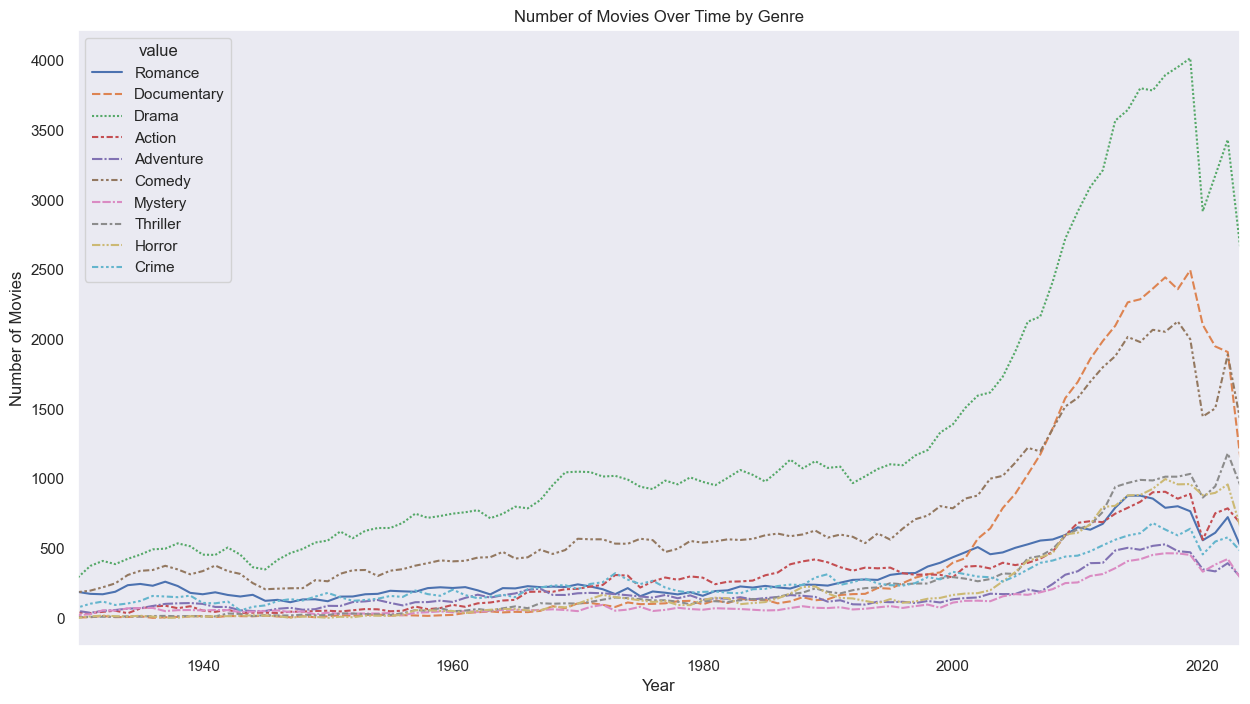

In [14]:
mean_ratings_by_genre = mean_ratings_by_genre.dropna(subset=['startYear'])
mean_ratings_by_genre = mean_ratings_by_genre.sort_values(by = ['startYear'])

mean_ratings_by_genre = mean_ratings_by_genre[mean_ratings_by_genre['startYear'].notna()]

# Convert 'startYear' to numeric, coercing non-numeric values to NaN
mean_ratings_by_genre['startYear'] = pd.to_numeric(mean_ratings_by_genre['startYear'], errors='coerce')

# Filter mean_ratings_by_genre to include only the top 10 genres
mean_ratings_top_genres = mean_ratings_by_genre[mean_ratings_by_genre['value'].isin(top_10_genres.index)]

# Create a line plot with 'startYear' on the x-axis, 'count' on the left y-axis, and 'averageRating' on the right y-axis
plt.figure(figsize=(15, 8))
average_rating_lines = sns.lineplot(
    data=mean_ratings_top_genres, 
    x = 'startYear', 
    y = 'count', 
    hue = 'value', 
    style = 'value', 
    palette = 'deep', 
    dashes = True,
    sizes = (0.5,3),
    legend = 'full'
)

plt.title('Number of Movies Over Time by Genre')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xlim(1930, 2023)
plt.show()

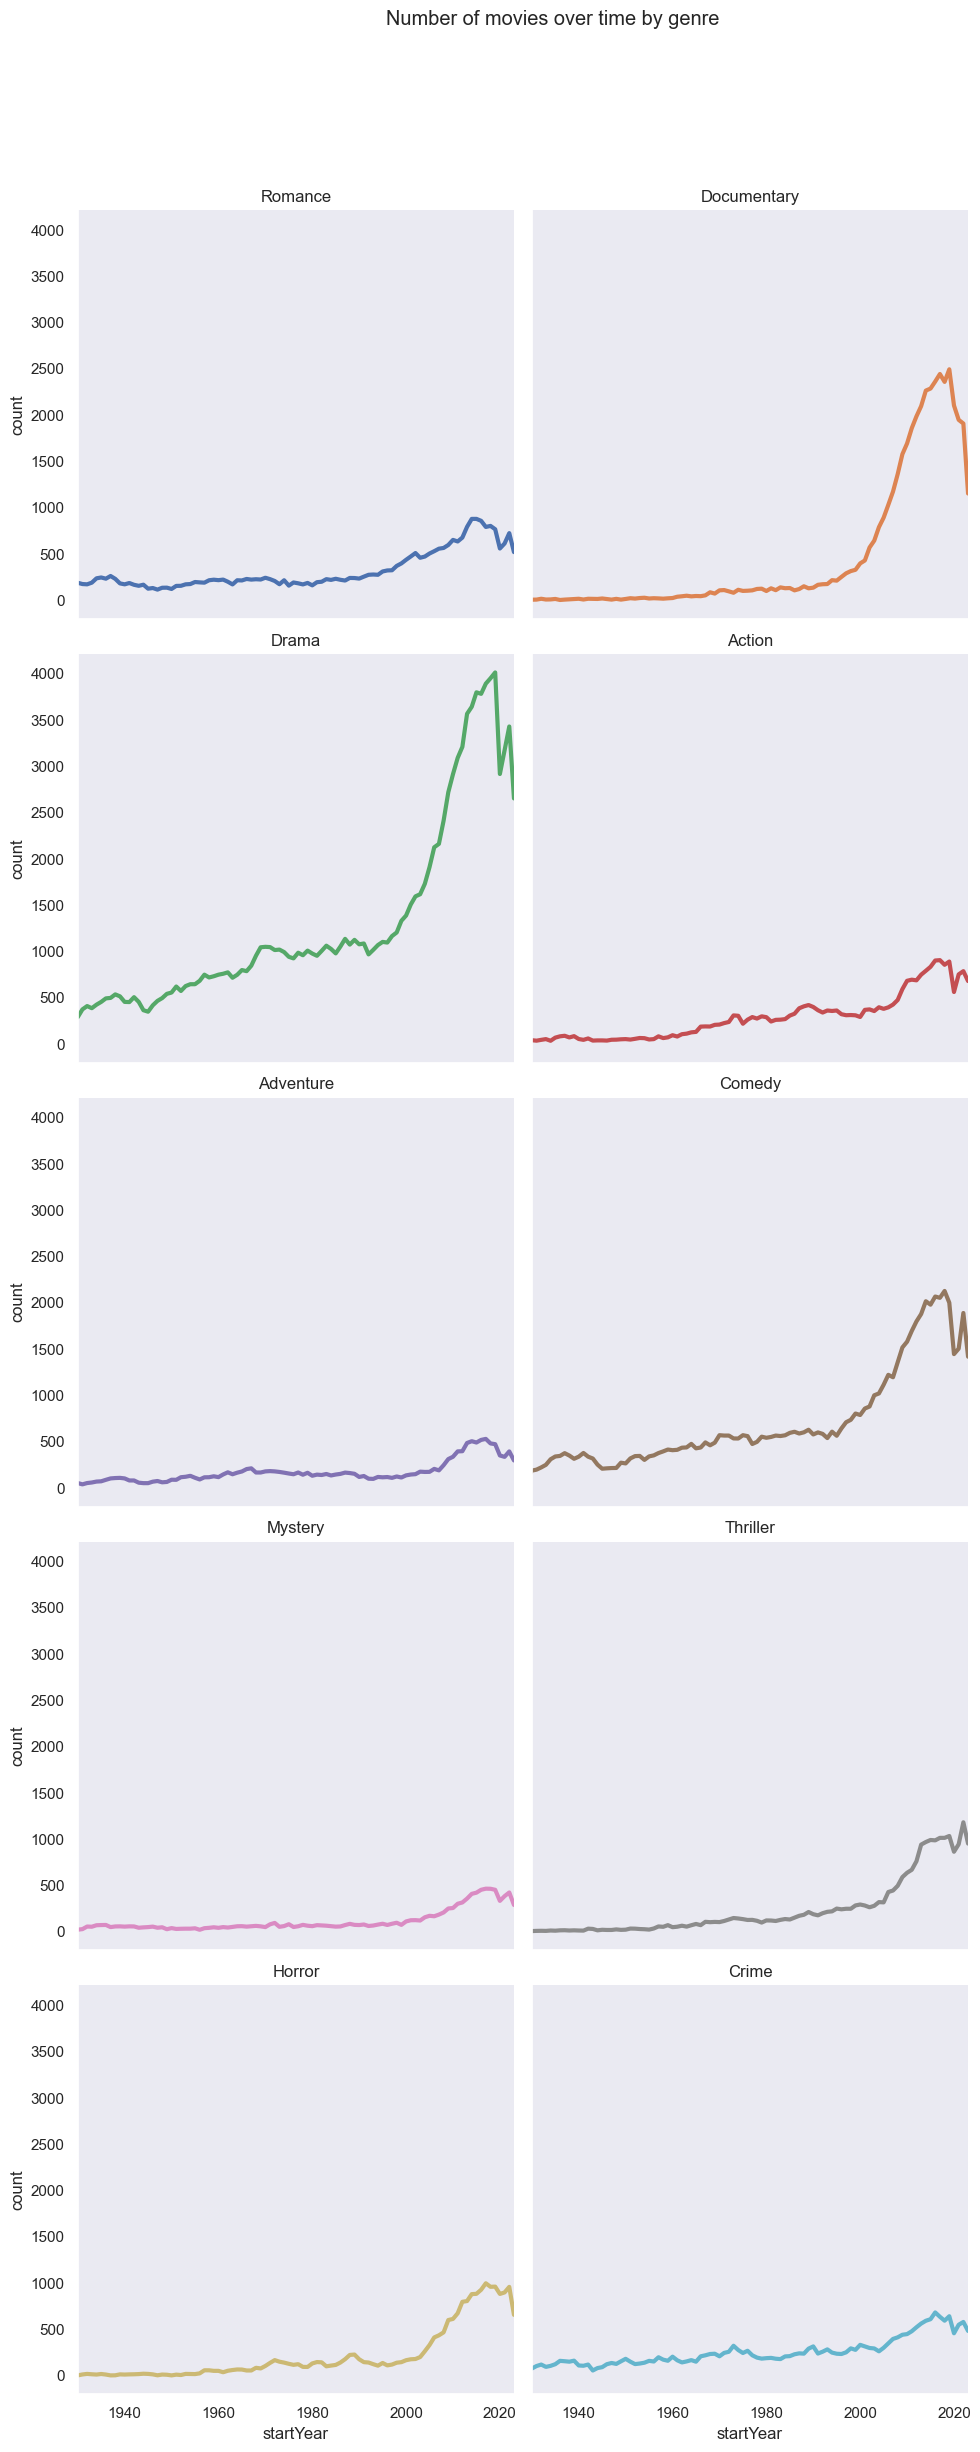

In [15]:
count_grid = sns.relplot(
    data = mean_ratings_top_genres, 
    x = "startYear", 
    y = "count",
    hue = "value", 
    col = "value", 
    col_wrap = 2,  
    height = 5,   
    aspect = 1,
    linewidth = 3,
    kind = "line"
)
plt.xlim(1930,2023)
#Legend wasn't necessary since each graph has a title.
count_grid._legend.remove()

count_grid.set_titles("{col_name}")
count_grid.fig.suptitle("Number of movies over time by genre")
#Suptitle was too close to graph titles, so adding more space at the top)
plt.subplots_adjust(top = 0.9)
plt.show()

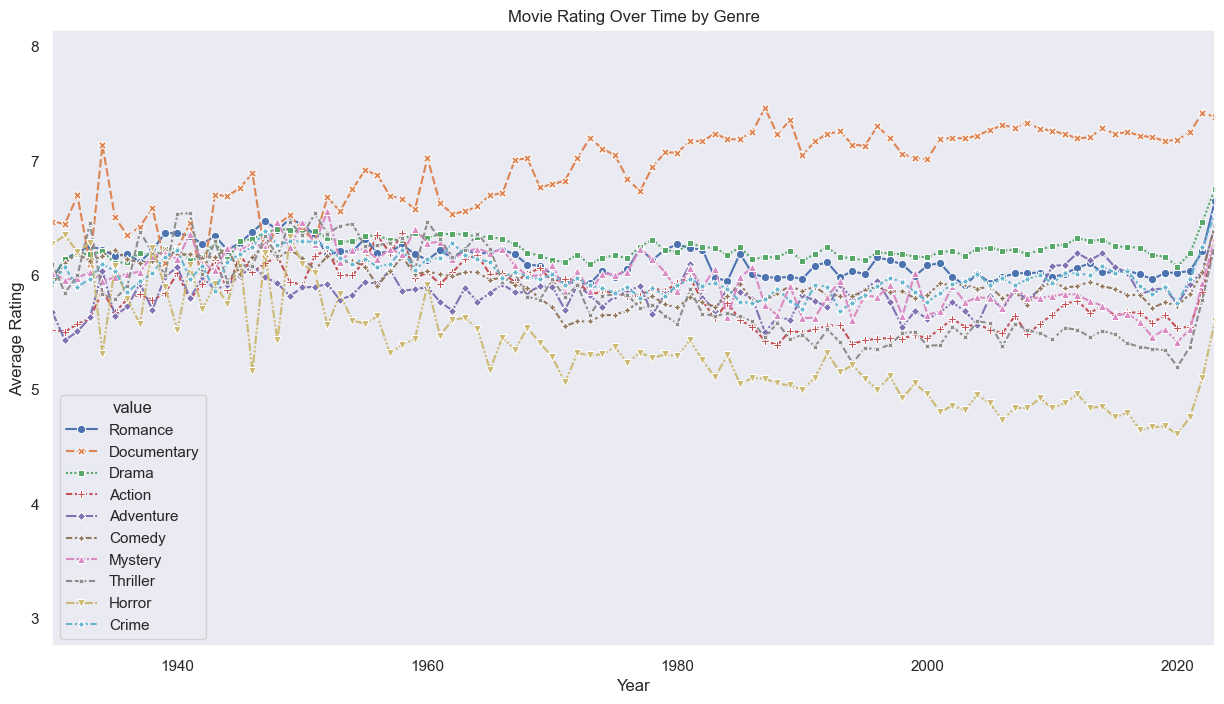

In [16]:
plt.figure(figsize=(15, 8))
sns.lineplot(
    data = mean_ratings_top_genres, 
    x ='startYear', 
    y ='averageRating', 
    hue ='value', 
    style = 'value', 
    palette ='deep', 
    markers = True,
    sizes = (0.5,3),
    legend = 'full'
)
plt.title('Movie Rating Over Time by Genre')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xlim(1930, 2023)
plt.show()

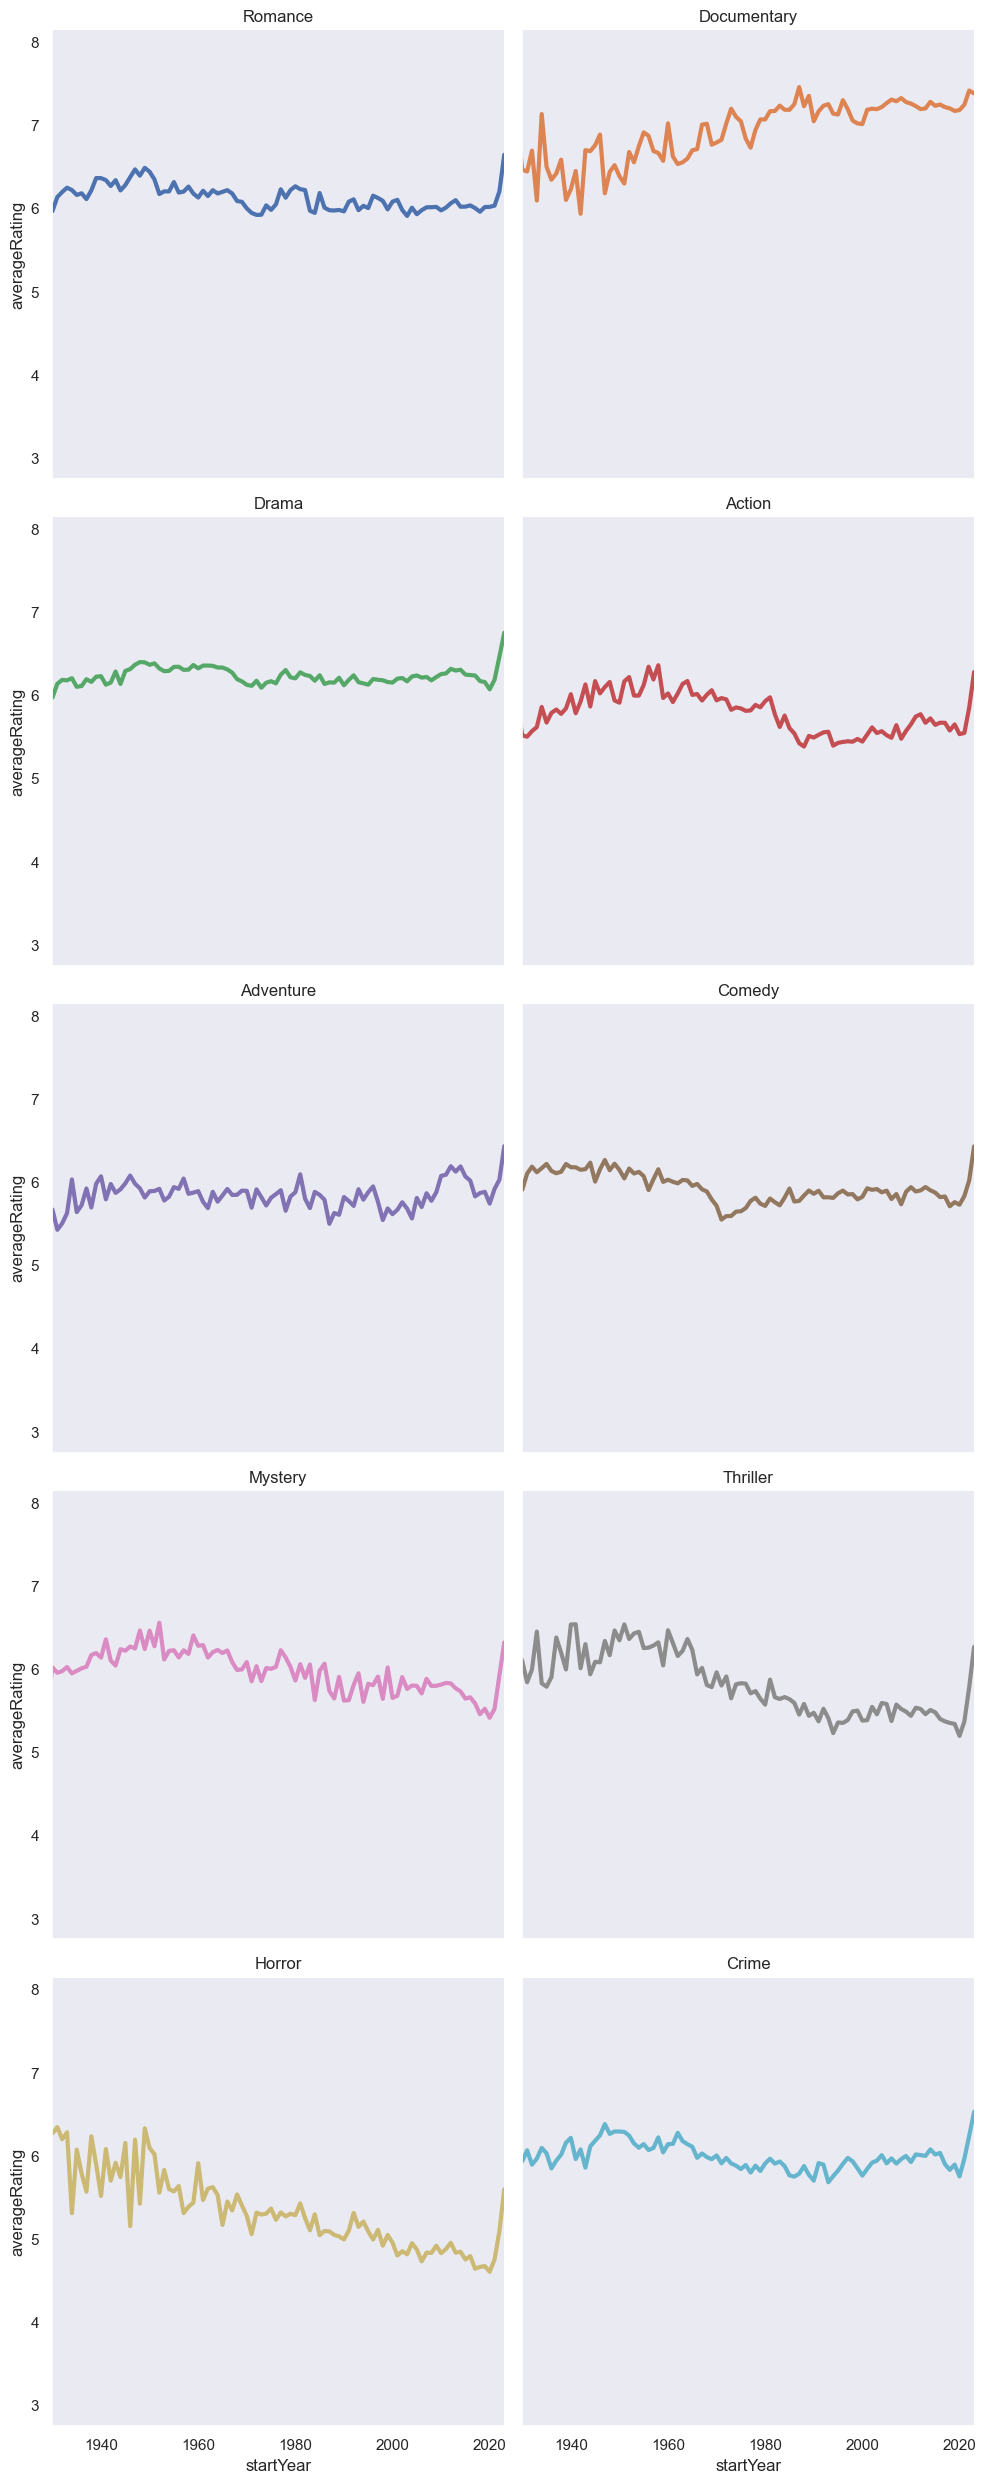

In [17]:
rating_grid = sns.relplot(
    data = mean_ratings_top_genres, 
    x = "startYear", 
    y = "averageRating",
    hue = "value", 
    col = "value", 
    col_wrap = 2,  
    height = 5,   
    aspect = 1,
    linewidth = 3,
    legend = False,
    kind = "line"
)
plt.xlim(1930,2023)

rating_grid.set_titles("{col_name}")
plt.show()

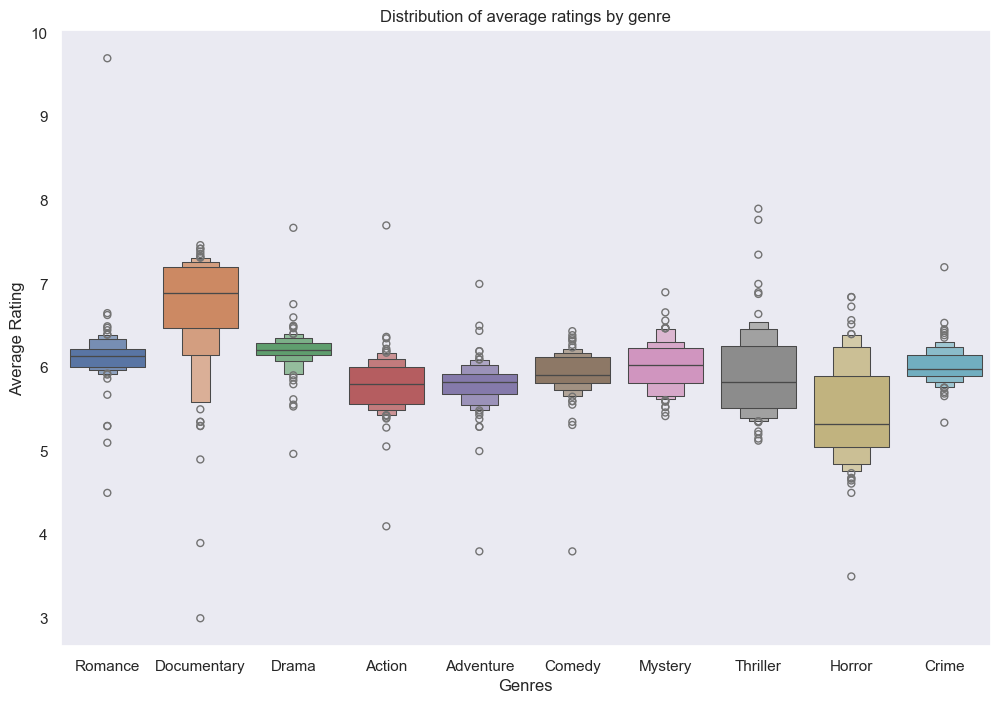

In [18]:
#Creating boxenplots to see distribution of average ratings and number of votes across genres
plt.figure(figsize=(12, 8))
rating_distribution_cakes = sns.boxenplot(
    data = mean_ratings_top_genres, 
    x='value', 
    y='averageRating', 
    hue='value', 
    palette='deep', 
    legend=False
)

plt.title("Distribution of average ratings by genre")
plt.xlabel("Genres")
plt.ylabel("Average Rating")
plt.show()

The graph above shows a distribution of average ratings for movies of different genres.
Some genres have a more spread out distribution of ratings, with the most spread out data in the Horror and Documentary genres.
While Documentaries have a much higher average tahn other genres, there are fewer outliers with a higher average rating. 

Positively skewed genres:

* Drama
* Comedy
* Thriller
* Horror
* Crime

Negatively skewed genres:

* Documentary
* Adventure
* Thriller

No skew or rather, less skewed:

* Action
* Mystery

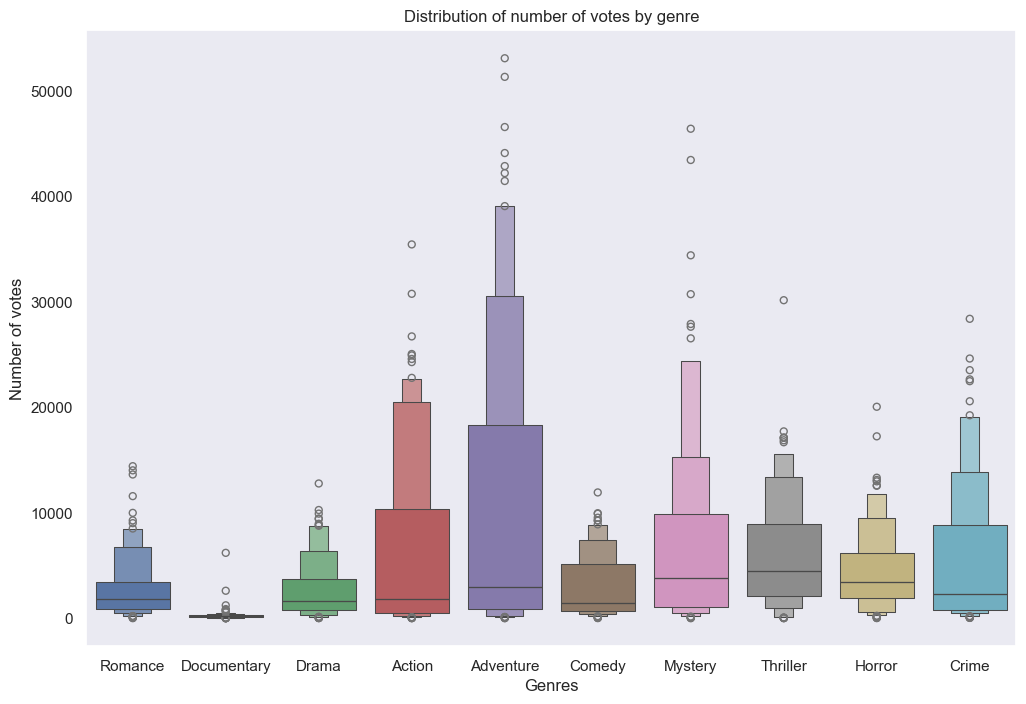

In [19]:
plt.figure(figsize=(12, 8))
votes_distribution_cakes = sns.boxenplot(
    data=mean_ratings_top_genres, 
    x='value', 
    y='numVotes', 
    hue='value', 
    palette='deep', 
    legend=False
)

plt.title("Distribution of number of votes by genre")
plt.xlabel("Genres")
plt.ylabel("Number of votes")
plt.show()

Based on this distribution, some genres get far more votes than others, with Adventure movies having the most votes. 
That said, the median number of votes for Mystery is higher, but seems to suggest fewer outliers.
While documentaries have the highest average rating out of all genres, they lag far behind in the number of votes. This may suggest that people who already like documentaries watch more documentaries and enjoy what they are seeing, while other genres get a more random viewership.

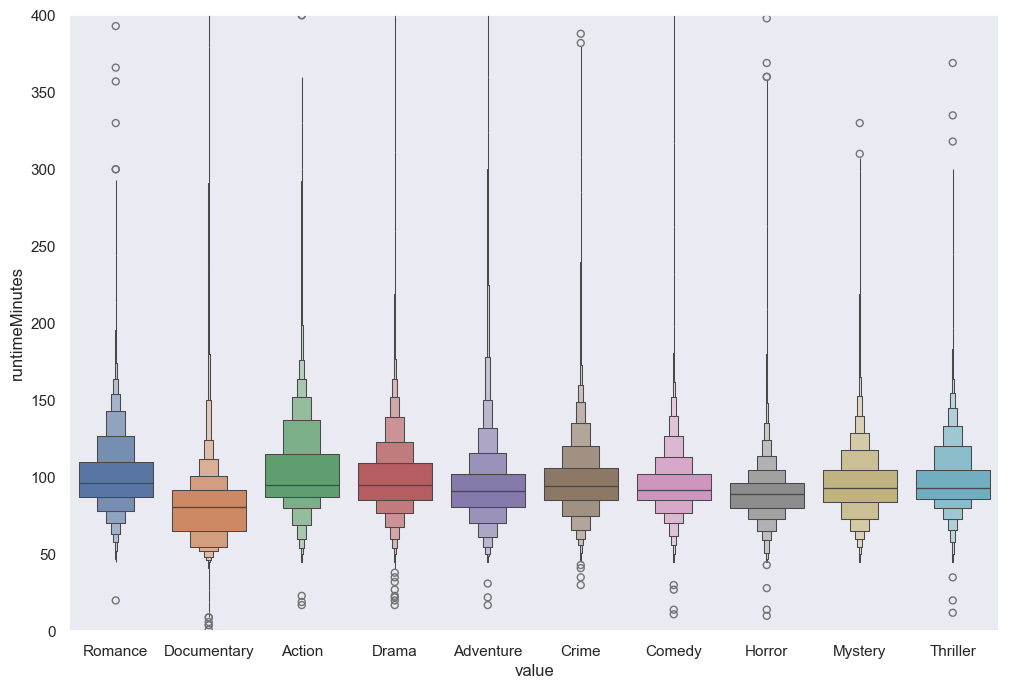

In [20]:
names_and_ratings_df_melted['runtimeMinutes'] = pd.to_numeric(names_and_ratings_df_melted.runtimeMinutes, errors = 'coerce')

top_genres_ratings = names_and_ratings_df_melted[names_and_ratings_df_melted['value'].isin(top_10_genres.index)]

plt.figure(figsize = (12,8))
sns.boxenplot(
    data = top_genres_ratings,
    x = "value",
    y = "runtimeMinutes",
    hue = 'value',
    palette = 'deep'
)

plt.ylim(0,400)
plt.show()

Some genres seem to have  higher rating on average than others. For example, Documentaries have both a higher average and lower standard deviation, meaning that Documentaries generally perform better with users. The average number of votes for Documentaries is much lower, which could indicate that the people watching Documentraries are a niche audience and generally like what they are seeing.

For all genres, the number of votes is quite skewed, with a high difference between the median and the mean. This means there are lots of movies that don't get many votes at all, while the other half of movies gets significantly more votes, thus pulling the average number of vtotes up.

Is there a combination of genres that leads to a higher rating on average? Let's find out.

In [52]:
#Melted DF includes rows for movies witohut a second or third gnere, with value for those duplicate rows equal to None.

names_and_ratings_df_melted_corrected = names_and_ratings_df_melted[names_and_ratings_df_melted.value.notna()]

movies_with_multiple_genres = names_and_ratings_df_melted_corrected.tconst.value_counts()

display(movies_with_multiple_genres.head(10))
display(names_and_ratings_df_melted_corrected.primaryTitle.value_counts().head(10))

tconst
tt1040036    3
tt0275067    3
tt4523530    3
tt4523698    3
tt0275170    3
tt0275113    3
tt0275097    3
tt0275094    3
tt0275086    3
tt0275085    3
Name: count, dtype: int64

primaryTitle
Mother                  46
Hero                    42
Love                    41
Solo                    39
Rage                    39
Homecoming              39
First Love              37
Alone                   37
The Three Musketeers    36
The Stranger            36
Name: count, dtype: int64

I didn't realize those were the most common movie titles:

* Mother                  46
* Hero                    42
* Love                    41
* Solo                    39
* Rage                    39
* Homecoming              39
* First Love              37
* Alone                   37
* The Three Musketeers    36
* The Stranger            36

Perhaps those are the most fundamental stories or emotions that people want to show in cinema. 

In [59]:
multi_genre_movies = names_and_ratings_df_melted_corrected[names_and_ratings_df_melted_corrected.tconst.isin(movies_with_multiple_genres.index[movies_with_multiple_genres.gt(1)])]
display(multi_genre_movies.head())

display(multi_genre_movies.size)


,averageRating,endYear,isAdult,numVotes,originalTitle,primaryTitle,runtimeMinutes,startYear,tconst,titleType,variable,value
1,5.3,\N,0,484.0,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,100,1897,tt0000147,movie,genre_1,Documentary
2,6.0,\N,0,857.0,The Story of the Kelly Gang,The Story of the Kelly Gang,70,1906,tt0000574,movie,genre_1,Action
7,5.0,\N,0,70.0,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,120,1908,tt0000679,movie,genre_1,Adventure
18,3.8,\N,0,21.0,Don Juan de Serrallonga,Don Juan de Serrallonga,58,1910,tt0001184,movie,genre_1,Adventure
21,5.4,\N,0,59.0,The Life of Moses,The Life of Moses,50,1909,tt0001285,movie,genre_1,Biography


4192260

In [68]:
# Concatenate genres for each movie into a single string
multi_genre_movies['genre_combination'] = multi_genre_movies.groupby('tconst')['value'].transform(lambda x: '+'.join(x))

/var/folders/ms/k8b53l1s5t1620nq2r0qr7y00000gn/T/ipykernel_25227/787210017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_genre_movies['genre_combination'] = multi_genre_movies.groupby('tconst')['value'].transform(lambda x: '+'.join(x))


genre_combination
Action+Adventure              6.106061
Action+Adventure+Animation    6.798723
Action+Adventure+Biography    7.050000
Action+Adventure+Comedy       5.806667
Action+Adventure+Crime        5.809524
                                ...   
Sci-Fi+Thriller               5.486667
Thriller+War                  6.566667
Thriller+War+Western          6.600000
Thriller+Western              6.200000
War+Western                   7.200000
Name: averageRating, Length: 664, dtype: float64


In [73]:
# Calculate the mean rating for each unique combination of genres
mean_ratings = multi_genre_movies[multi_genre_movies['numVotes'] >= 2000].groupby('genre_combination')['averageRating'].mean()

# Find the combination with the highest average rating

print(mean_ratings)

genre_combination
Action+Adventure                   6.106061
Action+Adventure+Animation         6.798723
Action+Adventure+Biography         7.050000
Action+Adventure+Comedy            5.806667
Action+Adventure+Crime             5.809524
Action+Adventure+Drama             6.340367
Action+Adventure+Family            5.787805
Action+Adventure+Fantasy           5.640237
Action+Adventure+History           6.083333
Action+Adventure+Horror            4.922727
Action+Adventure+Mystery           6.468182
Action+Adventure+Romance           6.252000
Action+Adventure+Sci-Fi            6.072376
Action+Adventure+Thriller          6.209474
Action+Adventure+War               7.033333
Action+Adventure+Western           6.300000
Action+Animation+Comedy            6.987500
Action+Animation+Crime             7.156250
Action+Animation+Drama             7.422222
Action+Animation+Family            5.966667
Action+Animation+Fantasy           7.096429
Action+Animation+Horror            6.240000
Action+Animati